In [27]:
#Importing necessary libraries
import numpy as np 
import pandas as pd 
import os
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D,LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from random import shuffle
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from keras import optimizers
from keras.models import *
from keras.layers import *

In [28]:
#for storing weights and checkpoints
my_temp_folder = "./"

In [6]:
#reading dataset
dataset = pd.read_csv("./IMDB Dataset.csv")

# Data visualisation

In [118]:
#checking for null values
dataset.isnull().values.any()

False

In [119]:
#checking number of rows and columns in the data via shape function
dataset.shape

(50000, 2)

In [160]:
dataset['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

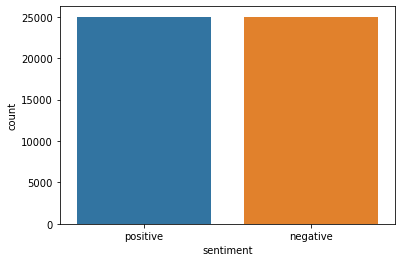

In [161]:
#checking for distribution of our target variable
sns.countplot(x='sentiment', data=dataset)

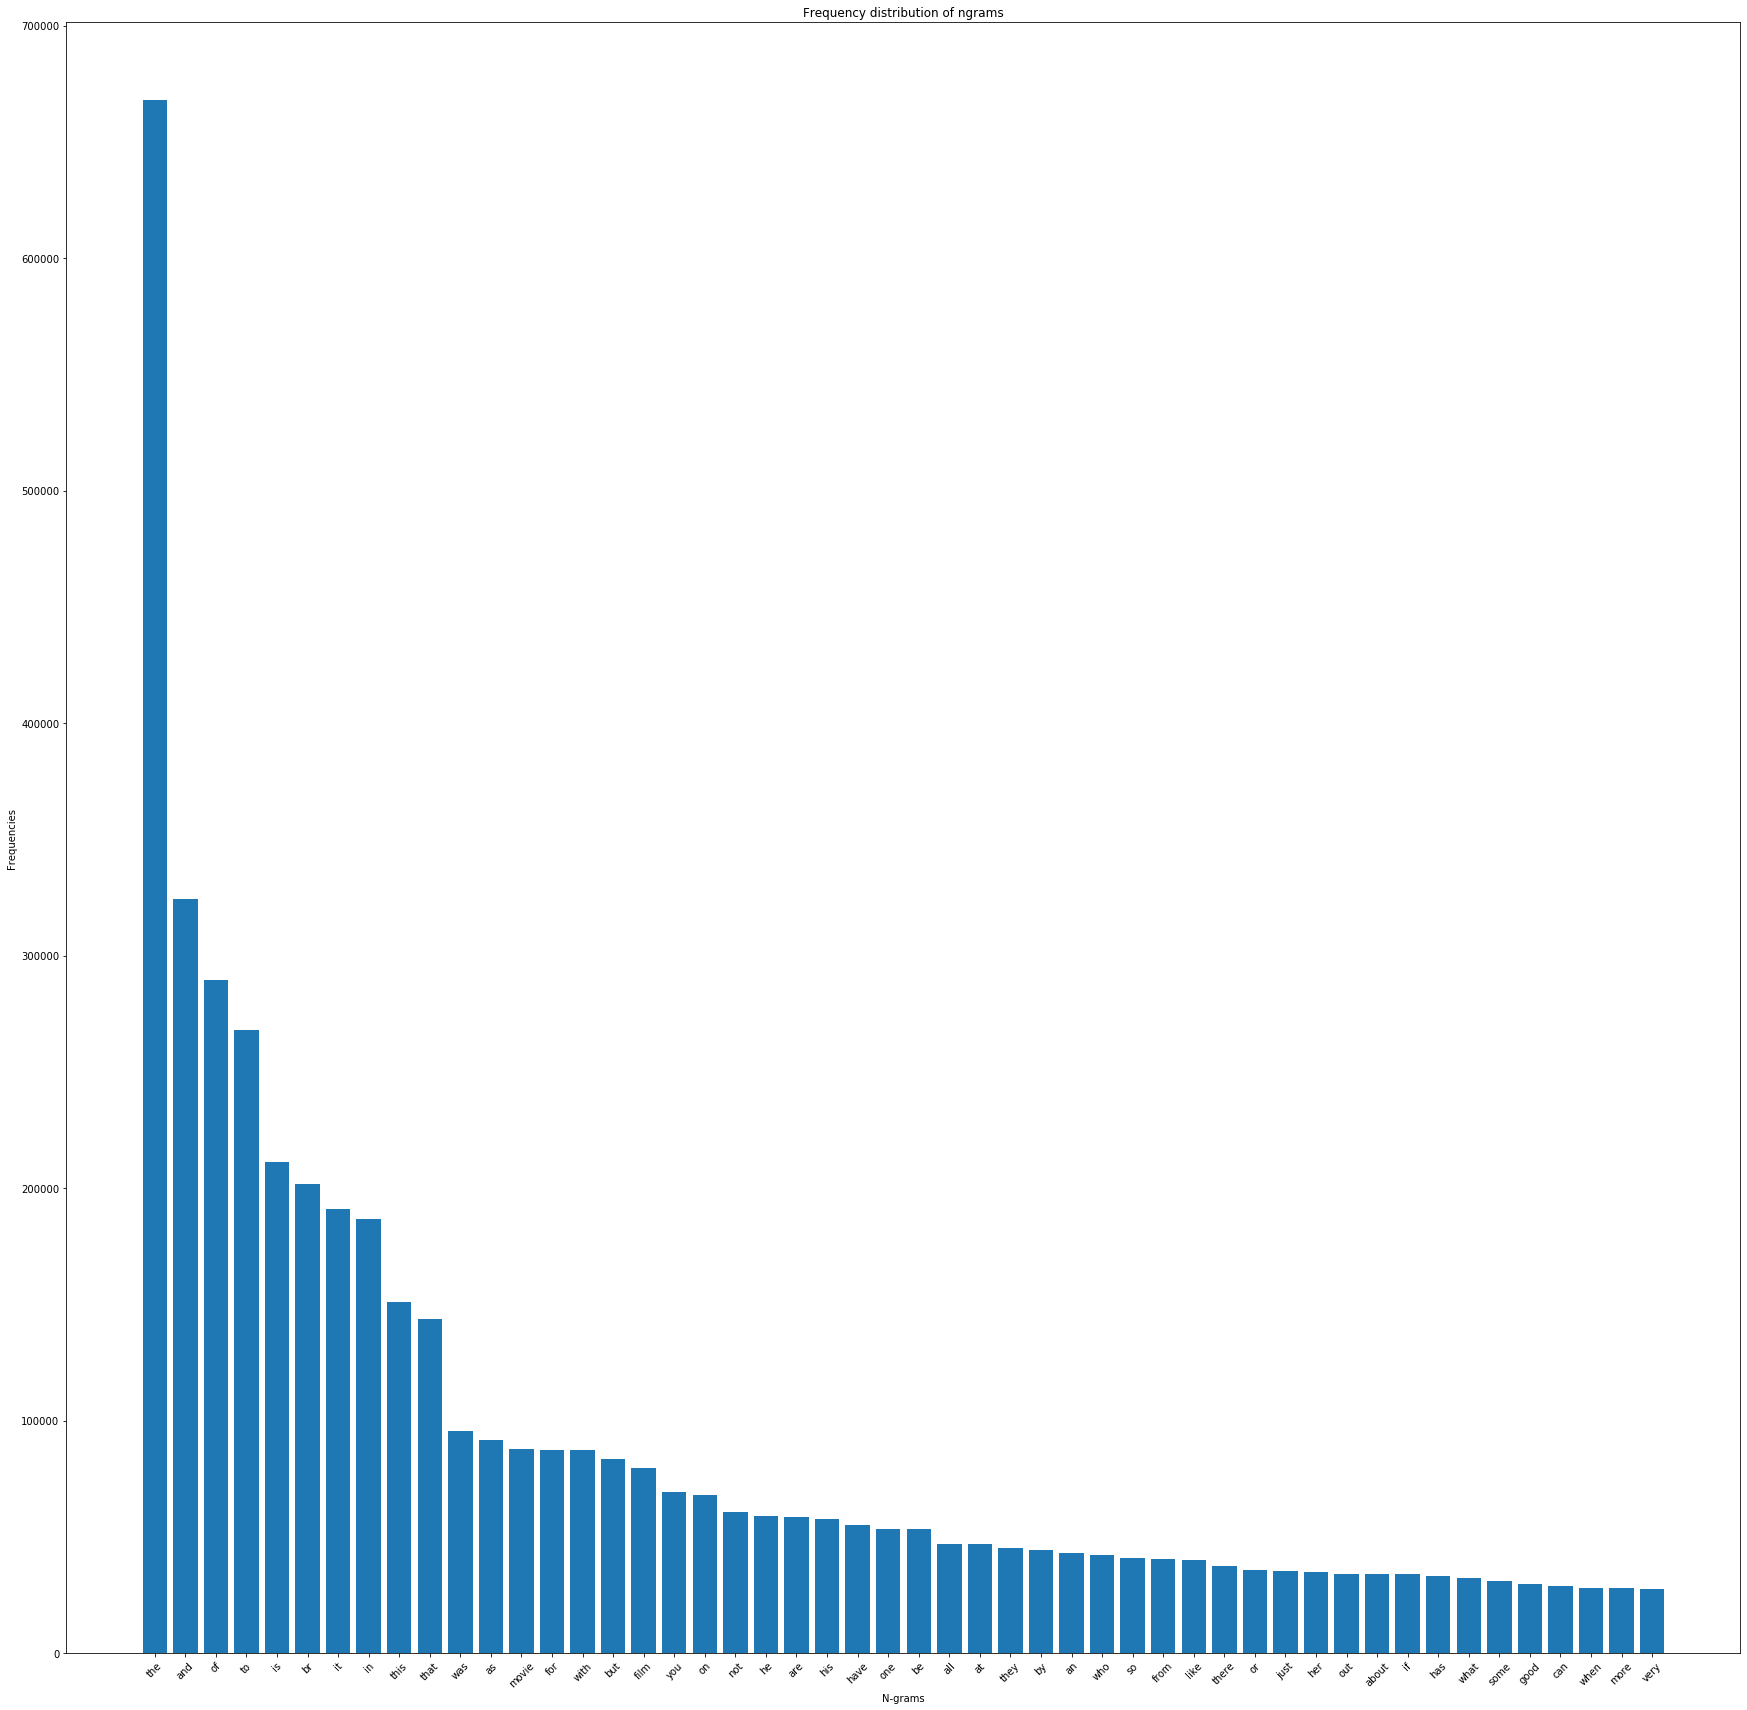

In [11]:
# some section of this chunk of code is taken from: https://www.kaggle.com/irinaabdullaeva/imdb-reviews-with-keras
#checking for most repeated words
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(dataset['review']))

#Counting frequency of words which are most frequent
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

As seen from the bar chart above, the highest frequency words are stop - words. We will not comsider them for our analysis as they dont provide much insights about a sentiment. 

# Pre-processing reviews

In [8]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocessing_text(text):
    # Remove html tag
    sentence = remove_tags(text)
    # Remove link
    sentence = re.sub(r'https:\/\/[a-zA-Z]*\.com',' ',sentence)
    # Remove number
    sentence = re.sub(r'\d+',' ',sentence)
    # Remove white space
    sentence = re.sub(r'\s+',' ',sentence)
    # Remove single character
    sentence = re.sub(r"\b[a-zA-Z]\b", ' ', sentence)
    # Remove bracket
    sentence = re.sub(r'\W+',' ',sentence)
    # Make sentence lowercase
    sentence = sentence.lower()
    return sentence

In [9]:
#pre processing sentences by removing html tags, links, white space, etc
pre_proces_sen = []
sentences = list(dataset['review'])
for sen in sentences:
    pre_proces_sen.append(preprocessing_text(sen))

In [8]:
print(pre_proces_sen[3])

basically there family where little boy jake thinks there zombie in his closet his parents are fighting all the time this movie is slower than soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re going to make film you must decide if its thriller or drama as drama the movie is watchable parents are divorcing arguing like in real life and then we have jake with his closet which totally ruins all the film expected to see boogeyman similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs as for the shots with jake just ignore them 


# Removing Stopwords

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [11]:
#this list is taken from https://www.ranks.nl/stopwords
stop = ['has', 'its', "needn't", 'm', "wouldn't", 'but', 'he', "mustn't", 'his', 'there', 'or', "won't", 'can',
        'd', "hadn't", 'how', 'hasn', 'very', 'wouldn', 'own', "doesn't", 'their', "isn't", 'an', "haven't",
        "wasn't", 'those', 'once', "shan't", 'when', "aren't", 've', 'it', "it's", 'of', "don't", 'and', 'down', 
        'yours', 'to', 'over', "she's", 'we', 'they', 'haven', 'having', 'ain', 'no', 'her', 'you', 'then', 'just',
        'didn', 'into', 'before', 'shouldn', 'here', 'yourselves', 's', 'will', 'which', 'are', 'who', 'with', "you'd", 
        'this', 'me', 'themselves', "you've", 'hadn', 'mightn', 'she', 'o', 'more', 'whom', 'for', 'him', 'again', 'below', 
        'few', 'most', 'been', 'such', 'shan', 'is', 'ourselves', 'y', 'by', 'being', 'in', 'mustn', "you'll", 'herself',
        'yourself', 'ours', 'between', 'had', 'other', "should've", 't', 'isn', 'them', 'himself', 're', 'doing', 'only',
        'where', 'your', 'after', 'so', 'll', 'against', 'the', 'about', 'each', 'aren', 'wasn', "couldn't", 'have', 'ma',
        'i', 'my', "mightn't", 'as', 'from', 'itself', 'under', 'same', 'why', 'any', 'our', 'be', 'off', "hasn't", 'through',
        "you're", 'was', 'did', "shouldn't", 'myself', 'some', 'theirs', 'hers', 'further', 'do', 'now', 'than', 'too', 
        'during', 'at', 'because', 'doesn','needn', "weren't", 'don', "didn't", 'couldn', 'what', 'does', 'if', 'up',
        'on', 'these', 'should', 'all', "that'll", 'above', 'weren', 'that', 'a', 'while', 'both', 'until', 'were', 'am']

In [12]:
#converting pre processed sentences to a vector by using word tokenizer
nltk.download('punkt')
for i in range(len(pre_proces_sen)):
    x = pre_proces_sen[i] 
    x = word_tokenize(x)
    new_x_list = [word for word in x if word not in stop]
    pre_proces_sen[i] = ' '.join(new_x_list)
    if i% 2000 == 0:
        print(i,end=" ")

[nltk_data] Downloading package punkt to C:\Users\Vaibhav
[nltk_data]     Gala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0 2000 4000 6000 8000 10000 12000 14000 16000 18000 20000 22000 24000 26000 28000 30000 32000 34000 36000 38000 40000 42000 44000 46000 48000 

In [10]:
print(pre_proces_sen[3])

basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots out well playing parents descent dialogs shots jake ignore


## Converting data to input and target variable
X = Input
Y = Target

In [13]:
y  = dataset['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X = pre_proces_sen

# Train | Test | Validation Split 

In [14]:
#splitting training and temporary into 50% each
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.50, random_state=42) 

#splitting validation and testing from temporary into 30% and 20% respectively.
X_val,X_test,y_val,y_test = train_test_split(X_tmp, y_tmp, test_size=0.40, random_state=42)

# Tokenization

In [15]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#creating sequence of tokenized words
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)


In [16]:
#padding the data as to make the sentences of equal length
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)


76134


 Creating directory below to save weights 

In [29]:
# Directory where the checkpoints will be saved
checkpoint_dir = my_temp_folder+'training_checkpoints'
import shutil
try:
    shutil.rmtree(checkpoint_dir)
except:
    print("directory not used yet.")

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    save_weights_only=True, 
    save_best_only=True)

directory not used yet.


# A. Models (RNN Variants)

## 1. Basic RNN

In [18]:
rnn_units = 128
BATCH_SIZE = 256
dropout_rate = 0.2

In [34]:
#model creation - Basic RNN
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300,input_length=maxlen))
model.add(tf.keras.layers.SimpleRNN(rnn_units))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               54912     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 22,903,433
Trainable params: 22,903,433
Non-trainable params: 0
__________________________________________

In [36]:
#compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [37]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback], verbose=1, validation_data = (X_val,y_val))

#evaluating test data over the model
score = model.evaluate(X_test, y_test, verbose=0)

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 75s 3ms/sample - loss: 0.6934 - accuracy: 0.5311 - val_loss: 0.6904 - val_accuracy: 0.5290
Epoch 2/6
25000/25000 [==============================] - 70s 3ms/sample - loss: 0.6015 - accuracy: 0.6567 - val_loss: 0.4764 - val_accuracy: 0.8110
Epoch 3/6
25000/25000 [==============================] - 70s 3ms/sample - loss: 0.3921 - accuracy: 0.8222 - val_loss: 0.7094 - val_accuracy: 0.5414
Epoch 4/6
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.2520 - accuracy: 0.8990 - val_loss: 0.6254 - val_accuracy: 0.7503
Epoch 5/6
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.0906 - accuracy: 0.9702 - val_loss: 0.5988 - val_accuracy: 0.7863
Epoch 6/6
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.6730 - val_accuracy: 0.8179


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7201352248191834
Test Accuracy: 0.8049


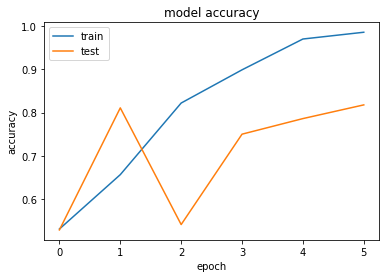

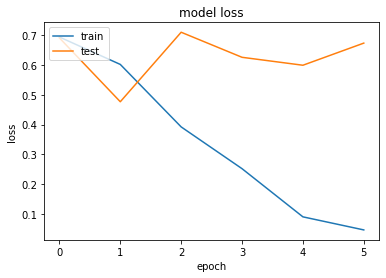

In [39]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 2. single layer LSTM

In [64]:
#model creation - single layer LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 23,064,009
Trainable params: 23,064,009
Non-trainable params: 0
__________________________________________

In [19]:
#compiling model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [20]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, verbose=1, callbacks=[checkpoint_callback], validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 166s 7ms/sample - loss: 0.5013 - accuracy: 0.7238 - val_loss: 0.3025 - val_accuracy: 0.8743
Epoch 2/6
25000/25000 [==============================] - 143s 6ms/sample - loss: 0.2041 - accuracy: 0.9252 - val_loss: 0.3174 - val_accuracy: 0.8777
Epoch 3/6
25000/25000 [==============================] - 149s 6ms/sample - loss: 0.0923 - accuracy: 0.9718 - val_loss: 0.3392 - val_accuracy: 0.8702
Epoch 4/6
25000/25000 [==============================] - 148s 6ms/sample - loss: 0.0551 - accuracy: 0.9844 - val_loss: 0.4259 - val_accuracy: 0.8640
Epoch 5/6
25000/25000 [==============================] - 148s 6ms/sample - loss: 0.0330 - accuracy: 0.9914 - val_loss: 0.5778 - val_accuracy: 0.8577
Epoch 6/6
25000/25000 [==============================] - 151s 6ms/sample - loss: 0.0224 - accuracy: 0.9942 - val_loss: 0.7876 - val_accuracy: 0.8589


In [21]:
#evaluating the LSTM model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7893308648943901
Test Accuracy: 0.8555


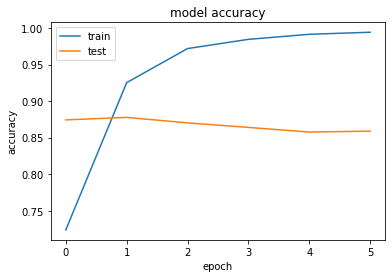

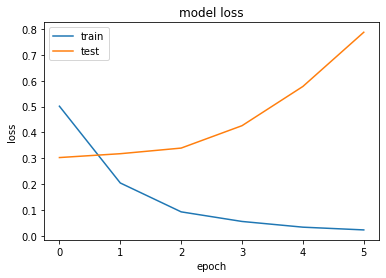

In [22]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 3. Multi- layer LSTM 

In [23]:
#Creating multi - LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen))
model.add(tf.keras.layers.LSTM(128,return_sequences = True))
model.add(tf.keras.layers.LSTM(128,return_sequences = False))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          22840200  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [25]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [26]:
#Training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, verbose=1, callbacks=[checkpoint_callback], validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 291s 12ms/sample - loss: 0.4886 - accuracy: 0.7428 - val_loss: 0.3262 - val_accuracy: 0.8676
Epoch 2/6
25000/25000 [==============================] - 362s 14ms/sample - loss: 0.2046 - accuracy: 0.9272 - val_loss: 0.3015 - val_accuracy: 0.8752
Epoch 3/6
25000/25000 [==============================] - 392s 16ms/sample - loss: 0.0941 - accuracy: 0.9710 - val_loss: 0.4795 - val_accuracy: 0.8666
Epoch 4/6
25000/25000 [==============================] - 414s 17ms/sample - loss: 0.0477 - accuracy: 0.9875 - val_loss: 0.4698 - val_accuracy: 0.8600
Epoch 5/6
25000/25000 [==============================] - 452s 18ms/sample - loss: 0.0438 - accuracy: 0.9872 - val_loss: 0.5741 - val_accuracy: 0.8599
Epoch 6/6
25000/25000 [==============================] - 466s 19ms/sample - loss: 0.0292 - accuracy: 0.9921 - val_loss: 0.6614 - val_accuracy: 0.8471


In [27]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6747713939368725
Test Accuracy: 0.8446


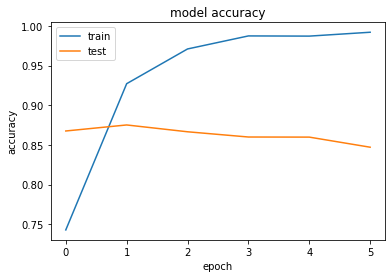

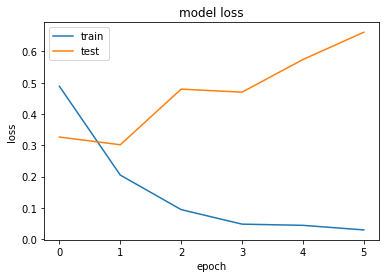

In [28]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [27]:
model.save('multi_lstm.h5')

# B. Models (Embeddings)

## 1. Distributed word embedding on CNN

In [41]:
#Link to download googles pretrained words can be found here 
#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit 

import gensim.models.keyedvectors as word2vec
from gensim.models import Word2Vec
#loading 1 million word vectors 
word2vec = word2vec.KeyedVectors.load_word2vec_format('F:\Semester 2\Deep Learning\Assignment 1\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000)

unable to import 'smart_open.gcs', disabling that module


In [42]:
#Assigning weights to our vocabulary from word2vec word vectors
embedding_weights = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    try:
        embedding_weights[index] = word2vec[word]
    except:
        pass 

In [32]:
#using pre - trained embedding on cnn 50 filters with size 4
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_weights],
                                     trainable = False))
model.add(tf.keras.layers.Conv1D(50, 4, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(10))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 50)            60050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 50)             0         
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 22,901,915
Trainable params: 61,715
Non-trainable params: 22,840,200
_____________________________________

In [34]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [35]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback], verbose=1, validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 26s 1ms/sample - loss: 0.4928 - accuracy: 0.7815 - val_loss: 0.3711 - val_accuracy: 0.8356
Epoch 2/6
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.3323 - accuracy: 0.8582 - val_loss: 0.3328 - val_accuracy: 0.8537
Epoch 3/6
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.2743 - accuracy: 0.8872 - val_loss: 0.3221 - val_accuracy: 0.8579
Epoch 4/6
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.2233 - accuracy: 0.9151 - val_loss: 0.3219 - val_accuracy: 0.8613
Epoch 5/6
25000/25000 [==============================] - 28s 1ms/sample - loss: 0.1751 - accuracy: 0.9380 - val_loss: 0.3253 - val_accuracy: 0.8642
Epoch 6/6
25000/25000 [==============================] - 29s 1ms/sample - loss: 0.1275 - accuracy: 0.9626 - val_loss: 0.3451 - val_accuracy: 0.8599


In [36]:
#evaluating the model based on test data 
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3532476469993591
Test Accuracy: 0.8567


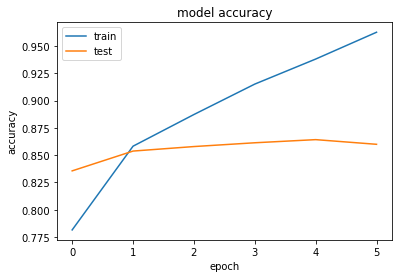

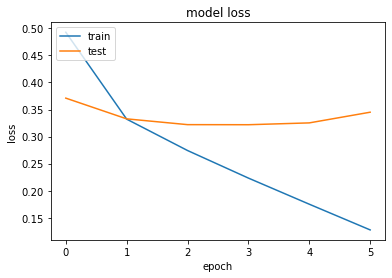

In [37]:
##generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Distributed word embedding on single LSTM

In [38]:
#using pre - trained embedding on single LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_weights],
                                     trainable = False))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 23,064,009
Trainable params: 223,809
Non-trainable params: 22,840,200
____________________________________

In [42]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [43]:
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback], verbose=1, validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 159s 6ms/sample - loss: 0.4155 - accuracy: 0.8202 - val_loss: 0.3684 - val_accuracy: 0.8433
Epoch 2/6
25000/25000 [==============================] - 156s 6ms/sample - loss: 0.3639 - accuracy: 0.8475 - val_loss: 0.3533 - val_accuracy: 0.8457
Epoch 3/6
25000/25000 [==============================] - 154s 6ms/sample - loss: 0.3489 - accuracy: 0.8515 - val_loss: 0.3406 - val_accuracy: 0.8547
Epoch 4/6
25000/25000 [==============================] - 154s 6ms/sample - loss: 0.3269 - accuracy: 0.8619 - val_loss: 0.3203 - val_accuracy: 0.8632
Epoch 5/6
25000/25000 [==============================] - 159s 6ms/sample - loss: 0.3121 - accuracy: 0.8678 - val_loss: 0.3272 - val_accuracy: 0.8636
Epoch 6/6
25000/25000 [==============================] - 167s 7ms/sample - loss: 0.3063 - accuracy: 0.8749 - val_loss: 0.3395 - val_accuracy: 0.8620


In [44]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3474022581577301
Test Accuracy: 0.859


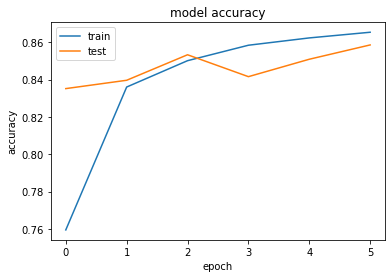

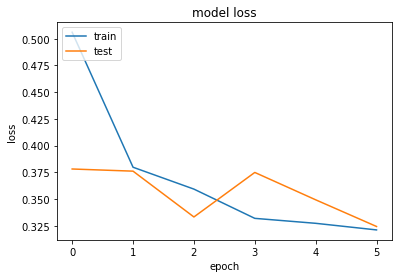

In [26]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

##  Distributed word embedding on multi LSTM

In [45]:
#using pre - trained embedding on multi LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen, weights=[embedding_weights],
                                     trainable = False))
model.add(tf.keras.layers.LSTM(128,return_sequences = True))
model.add(tf.keras.layers.LSTM(128,return_sequences = False))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [47]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], lr = '0.001')

In [48]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback], verbose=1, validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 320s 13ms/sample - loss: 0.4572 - accuracy: 0.7878 - val_loss: 0.3613 - val_accuracy: 0.8425
Epoch 2/6
25000/25000 [==============================] - 346s 14ms/sample - loss: 0.3564 - accuracy: 0.8452 - val_loss: 0.3405 - val_accuracy: 0.8496
Epoch 3/6
25000/25000 [==============================] - 354s 14ms/sample - loss: 0.3309 - accuracy: 0.8583 - val_loss: 0.3339 - val_accuracy: 0.8522
Epoch 4/6
25000/25000 [==============================] - 349s 14ms/sample - loss: 0.3262 - accuracy: 0.8623 - val_loss: 0.3328 - val_accuracy: 0.8607
Epoch 5/6
25000/25000 [==============================] - 356s 14ms/sample - loss: 0.3135 - accuracy: 0.8709 - val_loss: 0.3136 - val_accuracy: 0.8633
Epoch 6/6
25000/25000 [==============================] - 358s 14ms/sample - loss: 0.3000 - accuracy: 0.8761 - val_loss: 0.3000 - val_accuracy: 0.8709


In [49]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.30738613867759706
Test Accuracy: 0.8683


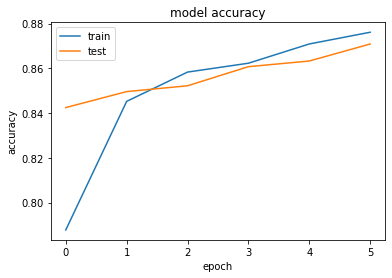

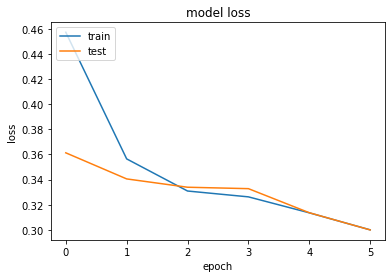

In [50]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Model (CNN)

## 1. CNN instead of LSTM

In [51]:
#using cnn with 50 filters of size 4
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen))
model.add(tf.keras.layers.Conv1D(50, 4, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(10))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          22840200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 50)            60050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 50)             0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1632      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

In [53]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], lr = '0.001')

In [54]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback],  verbose=1, validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 99s 4ms/sample - loss: 0.5719 - accuracy: 0.6986 - val_loss: 0.3780 - val_accuracy: 0.8377
Epoch 2/6
25000/25000 [==============================] - 96s 4ms/sample - loss: 0.3130 - accuracy: 0.8711 - val_loss: 0.3197 - val_accuracy: 0.8633
Epoch 3/6
25000/25000 [==============================] - 95s 4ms/sample - loss: 0.1289 - accuracy: 0.9576 - val_loss: 0.3472 - val_accuracy: 0.8616
Epoch 4/6
25000/25000 [==============================] - 95s 4ms/sample - loss: 0.0463 - accuracy: 0.9876 - val_loss: 0.4017 - val_accuracy: 0.8593
Epoch 5/6
25000/25000 [==============================] - 101s 4ms/sample - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.4550 - val_accuracy: 0.8597
Epoch 6/6
25000/25000 [==============================] - 97s 4ms/sample - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.5020 - val_accuracy: 0.8585


In [55]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5238808039307594
Test Accuracy: 0.8497


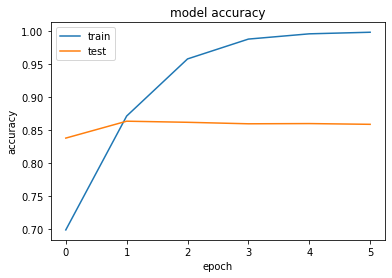

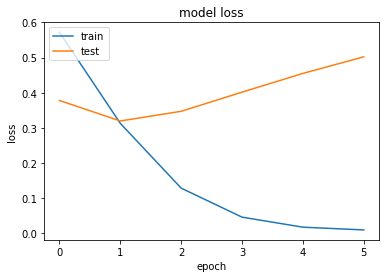

In [56]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 2. CNN above LSTM 

In [17]:
#using cnn with 50 filters of size 4
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 300, input_length=maxlen))
model.add(tf.keras.layers.Conv1D(50, 4, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(10))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(32,activation = 'relu'))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          22840200  
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 50)            60050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 50)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [19]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],lr = '0.001')

In [20]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback],  verbose=1, validation_data = (X_val,y_val))

Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 88s 4ms/sample - loss: 0.4587 - accuracy: 0.7712 - val_loss: 0.3054 - val_accuracy: 0.8697
Epoch 2/6
25000/25000 [==============================] - 76s 3ms/sample - loss: 0.1547 - accuracy: 0.9451 - val_loss: 0.3400 - val_accuracy: 0.8637
Epoch 3/6
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.0267 - accuracy: 0.9933 - val_loss: 0.4856 - val_accuracy: 0.8560
Epoch 4/6
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.7668 - val_accuracy: 0.8524
Epoch 5/6
25000/25000 [==============================] - 57s 2ms/sample - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.9328 - val_accuracy: 0.8513
Epoch 6/6
25000/25000 [==============================] - 57s 2ms/sample - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.8011 - val_accuracy: 0.8549


In [21]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8134740324407816
Test Accuracy: 0.8496


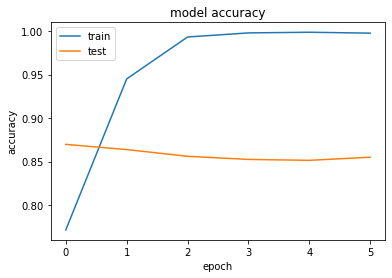

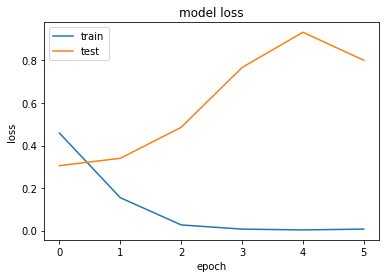

In [22]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# CNN with hetrogenous kernel size
## Hetrogeneous CNN instead of LSTM

In [19]:
num_words = vocab_size
max_len = maxlen
embed_size = 300
kernel_sizes = 2,3,4

In [24]:
#This helper function for hetrogeneous CNN is taken from the link below and later made some changes to it
#https://github.com/buomsoo-kim/Easy-deep-learning-with-Keras/blob/master/7.%20Text%20Analytics/3-CNNs-for-text-data/1-1D-convolution-for-text-analysis.ipynb
def one_dim_convolution_model_with_diff_kernels(num_words, embed_size, input_length, kernel_sizes):
    inputs = Input(shape = (X_train.shape[1],))
    embedded = Embedding(output_dim = embed_size, input_dim = num_words, input_length = max_len)(inputs)
    conv_results = []
    for kernel_size in kernel_sizes:
        x = Conv1D(50, kernel_size, activation = 'relu')(embedded)
        x = MaxPooling1D(pool_size = max_len - kernel_size + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)#concatinating results of filters
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(32, activation = 'softmax')(x)
    x = Dropout(rate=dropout_rate)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [25]:
#model creation
model = one_dim_convolution_model_with_diff_kernels(num_words, embed_size, max_len, kernel_sizes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     22840200    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 50)       30050       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 50)       45050       embedding_1[0][0]                
____________________________________________________________________________________________

In [30]:
##compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6, callbacks=[checkpoint_callback],  verbose=1,
                    validation_data = (X_val,y_val))

c:\users\vaibhav gala\python\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 62s 2ms/step - loss: 0.6501 - accuracy: 0.6864 - val_loss: 0.5685 - val_accuracy: 0.8197
Epoch 2/6
25000/25000 [==============================] - 62s 2ms/step - loss: 0.5307 - accuracy: 0.8454 - val_loss: 0.5115 - val_accuracy: 0.8553
Epoch 3/6
25000/25000 [==============================] - 65s 3ms/step - loss: 0.4603 - accuracy: 0.9007 - val_loss: 0.4772 - val_accuracy: 0.8587
Epoch 4/6
25000/25000 [==============================] - 63s 3ms/step - loss: 0.4025 - accuracy: 0.9275 - val_loss: 0.4521 - val_accuracy: 0.8609
Epoch 5/6
25000/25000 [==============================] - 65s 3ms/step - loss: 0.3627 - accuracy: 0.8904 - val_loss: 0.4369 - val_accuracy: 0.8574
Epoch 6/6
25000/25000 [==============================] - 62s 2ms/step - loss: 0.3352 - accuracy: 0.8814 - val_loss: 0.4195 - val_accuracy: 0.8612


In [32]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4265300361633301
Test Accuracy: 0.8551999926567078


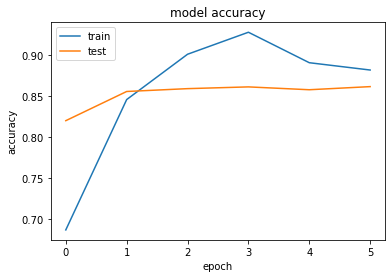

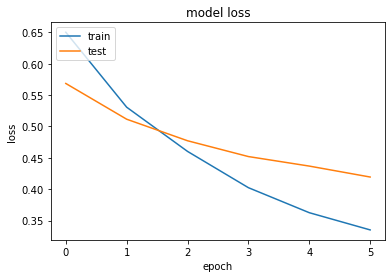

In [33]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Hetrogeneous CNN above LSTM

In [34]:
#This function for hetrogeneous CNN is taken from the link below and later made some changes to it
#https://github.com/buomsoo-kim/Easy-deep-learning-with-Keras/blob/master/7.%20Text%20Analytics/3-CNNs-for-text-data/1-1D-convolution-for-text-analysis.ipynb
kernel_sizes = 2,3,4
def one_dim_convolution_model_with_diff_kernels_above_lstm(num_words, embed_size, input_length, kernel_sizes):
    inputs = Input(shape = (X_train.shape[1],))
    embedded = Embedding(output_dim = embed_size, input_dim = num_words, input_length = max_len)(inputs)
    conv_results = []
    for kernel_size in kernel_sizes:
        x = Conv1D(50, kernel_size, activation = 'relu')(embedded)
        x = MaxPooling1D(pool_size = max_len - kernel_size + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = LSTM(128)(conv_result)
    x = Dropout(rate=dropout_rate)(x)
    x = Dense(32, activation = 'softmax')(x)
    x = Dropout(rate=dropout_rate)(x)
    outputs = Dense(1, activation = 'sigmoid')(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [35]:
#model creation
model = one_dim_convolution_model_with_diff_kernels_above_lstm(num_words, embed_size, max_len, kernel_sizes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     22840200    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 99, 50)       30050       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 98, 50)       45050       embedding_3[0][0]                
____________________________________________________________________________________________

In [36]:
#compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
#training the model
history = model.fit(X_train, y_train, batch_size=256, epochs=6,  verbose=1, 
                    validation_data = (X_val,y_val))

c:\users\vaibhav gala\python\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 15000 samples
Epoch 1/6
25000/25000 [==============================] - 64s 3ms/step - loss: 0.6474 - accuracy: 0.6668 - val_loss: 0.5681 - val_accuracy: 0.8125
Epoch 2/6
25000/25000 [==============================] - 63s 3ms/step - loss: 0.5310 - accuracy: 0.8175 - val_loss: 0.5091 - val_accuracy: 0.8587
Epoch 3/6
25000/25000 [==============================] - 61s 2ms/step - loss: 0.4595 - accuracy: 0.8429 - val_loss: 0.4723 - val_accuracy: 0.8675
Epoch 4/6
25000/25000 [==============================] - 63s 3ms/step - loss: 0.4079 - accuracy: 0.8663 - val_loss: 0.4511 - val_accuracy: 0.8663
Epoch 5/6
25000/25000 [==============================] - 62s 2ms/step - loss: 0.3731 - accuracy: 0.9121 - val_loss: 0.4316 - val_accuracy: 0.8694
Epoch 6/6
25000/25000 [==============================] - 61s 2ms/step - loss: 0.3451 - accuracy: 0.8831 - val_loss: 0.4186 - val_accuracy: 0.8698


In [38]:
#model evaluation on test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4248879264831543
Test Accuracy: 0.8626999855041504


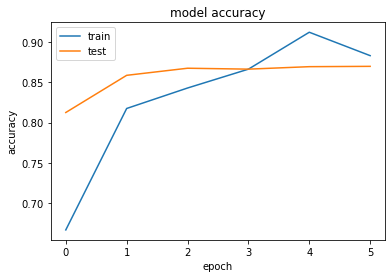

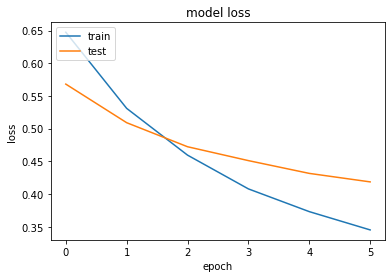

In [39]:
#generating graphs for validation accuracy and validaton loss
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Model Saving

In [49]:
model.save('word2vec_multiLSTM.h5')

In [58]:
#checking weights of the saved model
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[array([[-0.0734265 , -0.12987816,  0.08448296, ..., -0.20919386,
        -0.06003991, -0.02686682],
       [-0.01814746, -0.02486443,  0.39203423, ...,  0.63964444,
        -0.18660755, -0.02771507],
       [ 0.2809377 ,  0.02912817,  0.1225061 , ..., -0.5651099 ,
        -0.30067164, -0.18486443],
       ...,
       [ 0.07074205,  0.03788431, -0.03108753, ..., -0.31272134,
         0.05084706,  0.03697241],
       [ 0.0456548 , -0.07174367, -0.01680371, ..., -0.08588982,
         0.08691047,  0.03662943],
       [-0.05766624, -0.08979812,  0.00437673, ..., -0.08474962,
         0.00519219,  0.0444522 ]], dtype=float32), array([[-0.15011847, -0.11739078, -0.12497544, ..., -0.04060769,
        -0.30708736, -0.32037225],
       [-0.31443498, -0.18830621, -0.12347518, ..., -0.19972594,
        -0.24506421, -0.24676962],
       [ 0.07845689,  0.22916205, -0.12924315, ...,  0.05786628,
         0.3906078 ,  0.44566485],
       ...,
       [ 0.20216641,  0.07070868, -0.04067091, ..., -0.338